In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")

# Data Preparation

In [2]:
# Read in raw data
path = 'data/mmc2.csv'
raw = pd.read_csv(path)

# Engineering Classification Label (1.0 represents no change compared to wild-type)
def label_type(row):
    if row['scaled_effect'] < .99:
        return('Deleterious')
    elif row['scaled_effect'] > 1.1:
        return('Beneficial')
    else:
        return('Netural')
    
raw['Type'] = raw.apply(lambda row: label_type(row), axis=1)

# Filtering out "predicted" variants with no experimentally-determined ground truth
exp_data = raw[raw['predicted?'] == 'NO']
pred_data = raw[raw['predicted?'] == 'YES']


# List of Proteins
proteins = raw.protein.unique()
num_proteins = len(proteins)

print(proteins)
[print(x) for x in exp_data.columns]

exp_data.head()

['TEM-1' 'Kka2' 'Uba1' 'PSD95pdz3' 'Pab1' 'Yap65' 'hsp90' 'gb1']
variant_id
position_id
protein
dms_id
uniprot
scaled_effect
predicted?
position
aa1
aa2
wt_mut
aa1_polarity
aa2_polarity
aa1_pi
aa2_pi
delta_pi
grantham
aa1_weight
aa2_weight
delta_weight
aa1_volume
aa2_volume
delta_volume
aa1_psic
aa2_psic
delta_psic
local_density
accessibility
dssp_sec_str
phi_psi_reg
delta_solvent_accessibility
b_factor
mut_msa_congruency
mut_mut_msa_congruency
seq_ind_closest_mut
local_biochem
local_conservation
selection_coefficient
evolutionary_coupling_avg
predictions
Type


,variant_id,position_id,protein,dms_id,uniprot,scaled_effect,predicted?,position,aa1,aa2,...,b_factor,mut_msa_congruency,mut_mut_msa_congruency,seq_ind_closest_mut,local_biochem,local_conservation,selection_coefficient,evolutionary_coupling_avg,predictions,Type
0,beta-lactamase_0_E195F,beta-lactamase_0_195,TEM-1,beta-lactamase_0,P62593,-0.523520,NO,195,E,F,...,0.85,2.043,NaN,77.62,OAH,-2.02000,0.050084,0.004966,-0.523520,Deleterious
1,beta-lactamase_0_Q88W,beta-lactamase_0_88,TEM-1,beta-lactamase_0,P62593,-0.451832,NO,88,Q,W,...,2.03,0.400,NaN,77.62,APH,-1.53433,0.050084,0.005042,-0.451832,Deleterious
2,beta-lactamase_0_S104N,beta-lactamase_0_104,TEM-1,beta-lactamase_0,P62593,-0.409887,NO,104,S,N,...,0.57,1.148,NaN,63.29,HPO,-1.05267,0.050084,0.002181,-0.409887,Deleterious
3,kka2_1:2_D62Q,kka2_1:2_62,Kka2,kka2_1:2,P00552,-0.382303,NO,62,D,Q,...,0.08,10.048,10.048,64.39,PAA,-1.77833,0.295029,0.007442,-0.382303,Deleterious
4,beta-lactamase_0_A123M,beta-lactamase_0_123,TEM-1,beta-lactamase_0,P62593,-0.368171,NO,123,A,M,...,-0.72,1.308,NaN,41.26,PHH,-1.47367,0.050084,0.001016,-0.368171,Deleterious


## Exploration: Predicted versus Experimental Data

Because some of this data was predicted to fill in missing variants, let's see how big the true raw dataset really is.

In [145]:
exp_sum = 0
pred_sum = 0

for protein in proteins:
    exp = exp_data[exp_data['protein'] == protein]
    pred = pred_data[pred_data['protein'] == protein]
    
    exp_num = exp.shape[0]
    exp_sum += exp_num
    pred_num = pred.shape[0]
    pred_sum += pred_num
    
    print('Experimental Mutations in {}: {}'.format(protein, exp_num))
    print('Predicted Mutations in {}: {}\n'.format(protein, pred_num))
    
# Total Comparison
print('Experimental: {}\nPredicted: {}\n'.format(exp_sum, pred_sum))

Experimental Mutations in TEM-1: 30423
Predicted Mutations in TEM-1: 1617

Experimental Mutations in Kka2: 22490
Predicted Mutations in Kka2: 3910

Experimental Mutations in Uba1: 1604
Predicted Mutations in Uba1: 256

Experimental Mutations in PSD95pdz3: 1577
Predicted Mutations in PSD95pdz3: 83

Experimental Mutations in Pab1: 1206
Predicted Mutations in Pab1: 294

Experimental Mutations in Yap65: 373
Predicted Mutations in Yap65: 307

Experimental Mutations in hsp90: 180
Predicted Mutations in hsp90: 0

Experimental Mutations in gb1: 1045
Predicted Mutations in gb1: 55

Experimental: 58898
Predicted: 6522



## Exploration: Beneficial, Neutral, and Deleterious

In [141]:
for label in exp_data.Type.unique():
    print('Number of {} Mutations: {}'.format(label, exp_data[exp_data['Type'] == label].shape[0]))

Number of Deleterious Mutations: 36086
Number of Netural Mutations: 16760
Number of Beneficial Mutations: 6052


## Exploration: Single Protein Statistics for Scaled Effect and Categorical Labeling

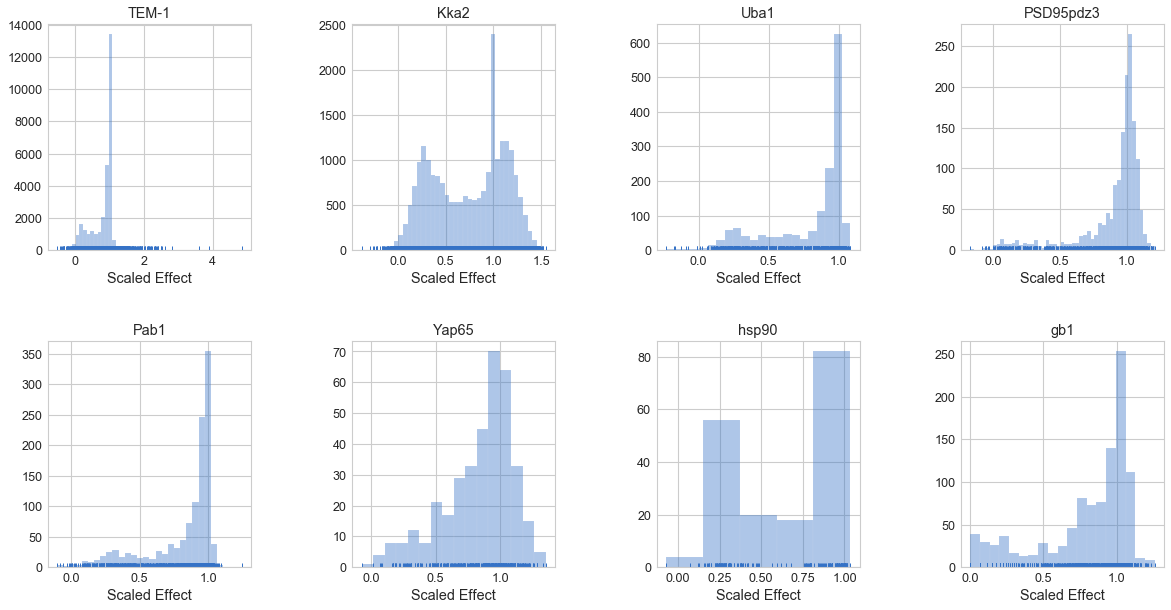

In [151]:
### Scaled Effect Histograms ###
figure,ax = plt.subplots(2,4, figsize = (20,10))
figure.subplots_adjust(hspace = 0.4, wspace = 0.5)
i = 1
    
for protein in proteins:
    raw = exp_data[exp_data['protein'] == protein]
    if i <= 4:
        sns.distplot(raw['scaled_effect'], ax = ax[0][i-1], kde = False, rug=True, rug_kws={'height': 0.02})
        ax[0][i-1].set(xlabel='Scaled Effect', title='{}'.format(protein))
    else:
        sns.distplot(raw['scaled_effect'], ax = ax[1][i-5], kde = False, rug=True, rug_kws={'height': 0.02})
        ax[1][i-5].set(xlabel='Scaled Effect', title='{}'.format(protein))
    i += 1

plt.savefig('img/scaled-effect-dist.png', dpi=300)

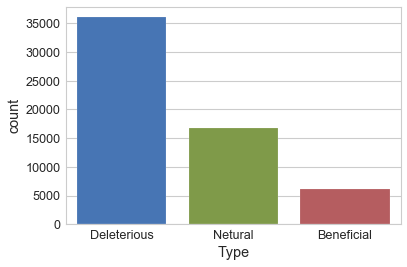

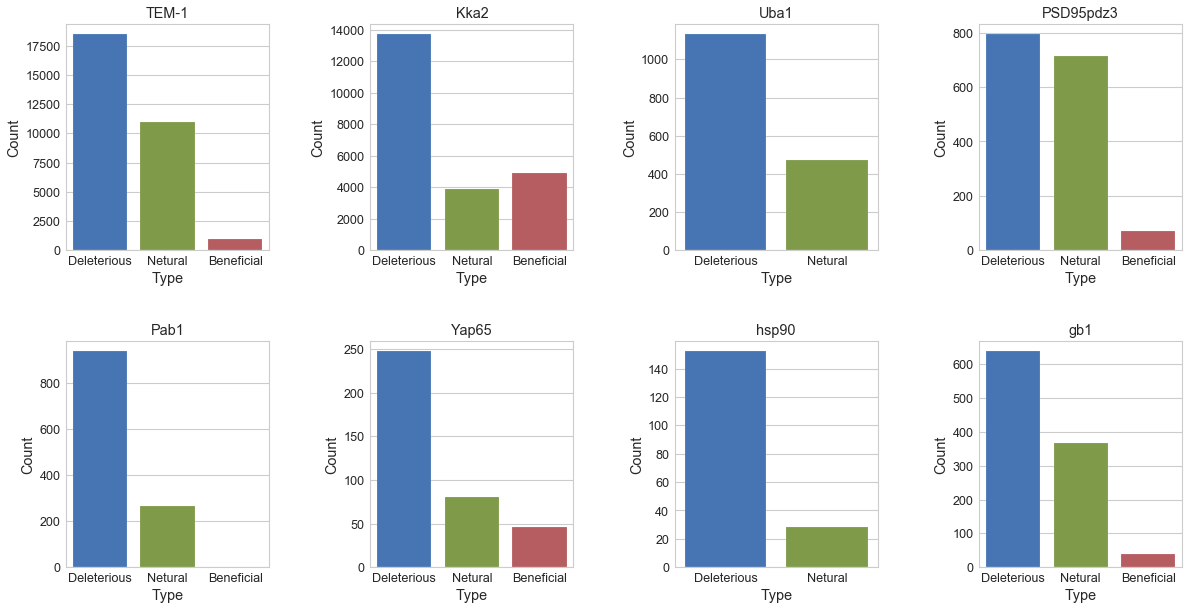

In [150]:
### Categorical Counts ###

ax = sns.countplot(x = 'Type', data=exp_data)


figure,ax = plt.subplots(2,4, figsize = (20,10))
figure.subplots_adjust(hspace = 0.4, wspace = 0.5)
i = 1

for protein in proteins:
    raw = exp_data[exp_data['protein'] == protein]
    if i <= 4:
        sns.countplot(x='Type', data=raw, ax = ax[0][i-1])
        ax[0][i-1].set(xlabel='Type', ylabel='Count', title='{}'.format(protein))
    else:
        sns.countplot(x='Type', data=raw, ax = ax[1][i-5])
        ax[1][i-5].set(xlabel='Type', ylabel='Count', title='{}'.format(protein))
    i += 1
    
plt.savefig('img/counts-per-protein.png', dpi=300)

## Baseline: LOPO Testing

To get a baseline, let's hold out Kka2, train a logistic regression model on the remaining protiens, and calculate the accuracy, ROC curves!

'TEM-1' 'Kka2' 'Uba1' 'PSD95pdz3' 'Pab1' 'Yap65' 'hsp90' 'gb1'

Potential Choices:
- variant_id
- position_id
- protein
- dms_id
- uniprot
- scaled_effect
- predicted?
- position
- aa1
- aa2
- wt_mut
- aa1_polarity
- aa2_polarity
- aa1_pi
- aa2_pi
- delta_pi
- grantham
- aa1_weight
- aa2_weight
- delta_weight
- aa1_volume
- aa2_volume
- delta_volume
- aa1_psic
- aa2_psic
- delta_psic
- local_density
- accessibility
- dssp_sec_str
- phi_psi_reg
- delta_solvent_accessibility
- b_factor
- mut_msa_congruency
- mut_mut_msa_congruency
- seq_ind_closest_mut
- local_biochem
- local_conservation
- selection_coefficient
- evolutionary_coupling_avg
- predictions
- Type

In [101]:
## Prep the data
key_cols = ['grantham','delta_pi', 'delta_weight', 'delta_volume', 'delta_psic', 'delta_solvent_accessibility', 
              'b_factor', 'mut_msa_congruency','Type']
predictors = ['grantham','delta_pi', 'delta_weight', 'delta_volume', 'delta_psic', 'delta_solvent_accessibility', 
              'b_factor', 'mut_msa_congruency']

train_data = exp_data[exp_data.protein != 'Kka2'][key_cols].dropna(axis=0, how='any')
test_data = exp_data[exp_data.protein == 'Kka2'][key_cols].dropna(axis=0, how='any')

In [102]:
x_train = train_data[predictors]
y_train = train_data['Type']
x_test = test_data[predictors]
y_test = test_data['Type']

/Users/anthonyagbay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anthonyagbay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.6159103335155823
Precision: 0.31523242914227106


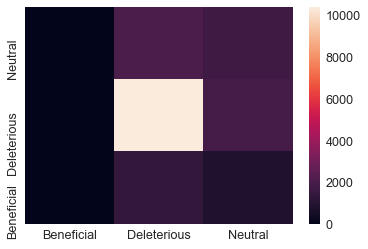

In [152]:
logreg = LogisticRegression(multi_class = 'ovr')
logreg.fit(x_train, y_train)
probs = logreg.predict_proba(x_test)

#Precision and Accuracy
predictions = logreg.predict(x_test)
precision = precision_score(y_test, predictions, average="macro")
score = logreg.score(x_test, y_test)
print('Accuracy: {}'.format(score))
print('Precision: {}'.format(precision))

# Confusion Matrix Heatmap
cmatrix = confusion_matrix(y_test, predictions)
sns.heatmap(cmatrix, xticklabels = ['Beneficial', 'Deleterious', 'Neutral'], yticklabels = ['Neutral', 'Deleterious', 'Beneficial'])
plt.savefig('img/kka2-lopo-logreg-cmatrix.png', dpi=300)

In [85]:
feature_data = pd.read_csv("data/pdb-files/pdb-shell1.ff", sep='\t', header=None)
feature_data.drop(columns =[81, 82, 83, 84, 85], inplace = True)